In [1]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import copy
import corner 
print(sys.executable)
sys.path.insert(0,'/home/cw1074/scarletmultisource/scarlet2')
sys.path.insert(0,'/home/cw1074/HSC/pulsars/scarlet')
import os
import scarlet
print(scarlet.__file__)
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping,AsinhPercentileNorm,show_scarlet2_scene,LinearPercentileNorm
import glob
import sep
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import numpyro.distributions as dist
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
from scarlet.source import StaticSource,MultiExtendedSource, StaticMultiExtendedSource
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import optax
from tqdm.auto import tqdm
import pandas as pd
from numpyro.distributions import constraints
import cmasher as cmr
from scarlet2 import *
import scarlet2
from scarlet2 import relative_step
print(scarlet2.__file__)
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde as kde
from scipy.stats import norm
from functools import partial
from skimage import draw
%matplotlib inline
import astrophot as ap
pixelscale=0.168

/home/cw1074/.conda/envs/scarlet/bin/python
/home/cw1074/HSC/pulsars/scarlet/scarlet/__init__.py


/home/cw1074/.conda/envs/scarlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/cw1074/scarletmultisource/scarlet2/scarlet2/__init__.py


In [3]:
def set_plot_style(doit=True,serif=True,use_tex=True):
    # NB -- for this to work
    # sudo apt install texlive-latex-base
    # sudo apt install msttcorefonts -qq
    # sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
    # rm ~/.cache/matplotlib -rf
    from matplotlib import cycler
    new_rcparams = {
        # Set color cycle: blue, green, yellow, red, violet, gray
        #'#axes.prop_cycle' : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set color cycle: blue, orange, green, red, violet, gray
        'axes.prop_cycle' : cycler('color', ['0C5DA5', 'FF9500', '00B945', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set default figure size
        'figure.figsize' : (4*1.5, 3*1.5),
        # Set x axis
        'xtick.direction' : 'in',
        'xtick.major.width' : 0.5,
        'xtick.minor.size' : 1.5*2,
        'xtick.minor.width' : 0.5,
        'xtick.minor.visible' : True,
        'xtick.top' : True,
        # Set y axis
        'ytick.direction' : 'in',
        'ytick.major.size' : 3*2,
        'ytick.major.width' : 0.5,
        'ytick.minor.size' : 1.5*2,
        'ytick.minor.width' : 0.5,
        'ytick.minor.visible' : True,
        'ytick.right' : True,
        # Set line widths
        'axes.linewidth' : 0.5,
        'grid.linewidth' : 0.5,
        'lines.linewidth' : 1.,
        # Remove legend' frame
        'legend.frameon' : False,
        # Always save as 'tight'
        'savefig.bbox' : 'tight',
        'savefig.pad_inches' : 0.05,
    }
    if use_tex:
        new_rcparams.update({
            # Use LaTeX for math formatting
            'text.usetex' : True,
            'text.latex.preamble' : r'\usepackage{amsmath}'
            })
    if serif:
        new_rcparams.update({
            # Use serif fonts
            'font.serif' : 'Times New Roman',
            'font.family' : 'serif',
            'mathtext.fontset' : 'dejavuserif',
            'legend.fontsize' : 'large',
            'xtick.labelsize' : 'x-large',
            'ytick.labelsize' : 'x-large',
            'axes.labelsize' : 'xx-large',
            })
    if doit:
        plt.rcParams.update(new_rcparams)
    else:
        return new_rcparams
set_plot_style()
plt.rcParams["font.family"] = "Serif"

Provide name and position of source, desired bands, and location of image data.

In [4]:
getphotometry = False
getgalaxySED = False
getoffset = True

bandall=['G','I','R','Y','Z']
sources = np.loadtxt('/home/cw1074/HSC/dwarf_agn_cosmos/hsc_agn_updated.txt',dtype=str,skiprows = 45,usecols = (10,1,2))
src = '826212'
indsrc = np.argwhere(sources[:,0]==src)[:,0]
row = sources[indsrc][0]
src=row[0]
srcname = row[0]
src=srcname
print(src)
ra=float(row[1])
dec=float(row[2])

datadir='/scratch/gpfs/cw1074/HSCdata2'
imagedir = datadir+'/'+src
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
plotdir = datadir+'/plots/'+src
if not os.path.isdir(plotdir):
    os.mkdir(plotdir)

coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')


826212


Define a function that stacks the images and performs source detection on the stack

In [5]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations[:5]])
    interps = normed_images#[scarlet.interpolation.interpolate_observation(obs, observations[0]) for obs in observations]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 5, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

For each band, obtain the science, weight and PSF images. Loop over each image and create scarlet1 and scarlet2 observation objects.

In [6]:
observations=[]
observations_sc2_old=[]
channels=[]
channels_sc2 =[]
times=[]
zps =[]
norms=[]
waves = [4754,7711,6175,9762,8898]
waveselect=[]
bandselect=[]
for band,w in zip(bandall,waves):
    imageout=[]
    psfs=[]
    imagetar = glob.glob(imagedir+'/warps-HSC-'+band+'*.tar')
    print(imagedir+'/warps-HSC-'+band+'*.tar')
    for fn in imagetar:
        taropen = tarfile.open(fn)
        #images = tarfile.getnames()
        taropen.extractall(imagedir)
        taropen.close()

    matchestar = glob.glob(imagedir+'/psf-warp-*-'+band+'-*.tar')
    for fn in matchestar:
        taropen = tarfile.open(fn)
        taropen.extractall(imagedir)
        taropen.close()
    images = glob.glob(imagedir+'/warps-HSC-'+band+'-*-pdr3_dud*/warp-*.fits')
    for fn in images:
        epochid = fn.split('/')[-1].split('-')[-1].rstrip('.fits')
        matches = glob.glob(imagedir+'/psf-*HSC-'+band+'*-'+epochid+'*.fits')    
        if len(matches)>0:
            imageout.append(fn)
            psfs.append(matches[0])
    print(len(imageout),'images')

    if band=='Y':
        maximg = 2#200
    else:
        maximg=2#160
    for ind,(img,psf) in enumerate(zip(imageout,psfs)):
        epochs = np.asarray([obs.channels[0][0] for obs in observations])
        if np.sum(epochs==band)>=maximg:
            break
        obs_hdu = fits.open(img)
        try:
            mjd = Time(obs_hdu[0].header['DATE-AVG'],format='isot',scale='utc').mjd
        except KeyError:
            print('No time')
            continue
        data_hsc = obs_hdu[1].data.byteswap().newbyteorder()
        N1, N2 = data_hsc.shape
        data_hsc = data_hsc.reshape(1, N1, N2)
        weight_hsc = np.reciprocal(obs_hdu[3].data)**2
        mask_hsc = obs_hdu[2].data
        mask_new = np.invert((mask_hsc==32)|(mask_hsc==64)|(mask_hsc==0)|(mask_hsc==2048))
        weight_hsc[mask_new] = 0
        weight_hsc[np.isnan(obs_hdu[1].data)] = 0
        if np.sum(weight_hsc==0)>0.001*weight_hsc.shape[-2]*weight_hsc.shape[-1]:
            print('Poor image, skipping')
            continue
        if w not in waveselect:
            waveselect.append(w)
        if band not in bandselect:
            bandselect.append(band)
        Nw1, Nw2 = weight_hsc.shape
        weight_hsc = weight_hsc.reshape(1, Nw1, Nw2)
        mask_hsc = mask_new.reshape(1, Nw1, Nw2)
        wcs_hsc = WCS(obs_hdu[1].header)
        channel = [band+str(ind)]
        channel_sc2 = (band, str(ind)) 
        channels.append(band+str(ind))
        channels_sc2.append(channel_sc2)
        psf_hsc0 = fits.open(psf)[0].data
        Np1, Np2 = psf_hsc0.shape
        p1,p2=psf_hsc0.shape
        
        if p1-37>0:
            psf_hsc0=psf_hsc0[int((p1-37)/2):-int((p1-37)/2),:]
        if p2-37>0:
            psf_hsc0=psf_hsc0[:,int((p2-37)/2):-int((p2-37)/2)]
        
        psf_hsc = scarlet.ImagePSF(psf_hsc0)
        r=1
        
        obs_hsc = scarlet.Observation(data_hsc,
                wcs=wcs_hsc,
                psf=psf_hsc,
                channels=channel,
                weights=weight_hsc)
        observations.append(obs_hsc)
        times.append(mjd)
        obs_sc2 = scarlet2.Observation(jnp.asarray(data_hsc), jnp.asarray(weight_hsc), psf=scarlet2.ArrayPSF(jnp.asarray([psf_hsc0,])),channels=[channel_sc2],wcs=wcs_hsc)
        observations_sc2_old.append(obs_sc2)
        norms.append(AsinhPercentileNorm(data_hsc,percentiles=[0.01,99.9]))#norms.append(AsinhMapping(minimum=-1, stretch=5, Q=3))
epochs = np.asarray([obs.channels[0][0] for obs in observations])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in observations],return_index=True)
bands = epochs[inds0]
repeats0 = np.asarray([np.sum([epochs==b]) for b in bands],dtype=int)

model_psf = scarlet.GaussianPSF(sigma=0.7)
model_frame,offset = scarlet.Frame.from_observations(observations, coverage='intersection', model_psf=model_psf)
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2_old),observations_sc2_old[0].data.shape[-1],observations_sc2_old[0].data.shape[-2])), psf=frame_psf_sc2, channels=channels_sc2)
print('Total images = ',len(observations_sc2_old))
print(channels_sc2)
print(waveselect)
for obs in observations_sc2_old:
    obs.match(model_frame_sc2)

/scratch/gpfs/cw1074/HSCdata2/826212/warps-HSC-G*.tar
83 images
Poor image, skipping
Poor image, skipping
Poor image, skipping
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/scratch/gpfs/cw1074/HSCdata2/826212/warps-HSC-I*.tar


/tmp/ipykernel_1242956/950855457.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.sum(epochs==band)>=maximg:


206 images
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
/scratch/gpfs/cw1074/HSCdata2/826212/warps-HSC-R*.tar
70 images
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
/scratch/gpfs/cw1074/HSCdata2/826212/warps-HSC-Y*.tar
233 images
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
Poor image, skipping
/scratch/gpfs/cw1074

Run source detection to create a catalog of source positions. Subtract background from images.

In [7]:
lvl = 3
wave = 3
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(observations, lvl, wave)
obssinglearr=np.asarray(observations)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr][0]
normsingle=[]
observations_sc2=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(observations,observations_sc2_old,bgsingle,globalback)):
    #obs.weights = np.ones(obs.shape) / (bg)[:, None, None]
    #Store norm based on observation data
    normsingle.append(LinearPercentileNorm(obs.data,percentiles=[0.1, 99.9]))
    obs.data = obs.data-back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),channels=[channels_sc2[ind]],wcs=wcs_hsc)
    observations_sc2.append(obs_sc2)

In [8]:
print(ra_dec[0],np.asarray(ra_dec).shape)
if np.asarray(ra_dec).shape==(2,):
    separ=[0]
    indtransient=0
    ra_dec=[ra_dec]
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)

[150.1028073    2.55065891] (3, 2)


Plot the first couple of images

(3, 2)


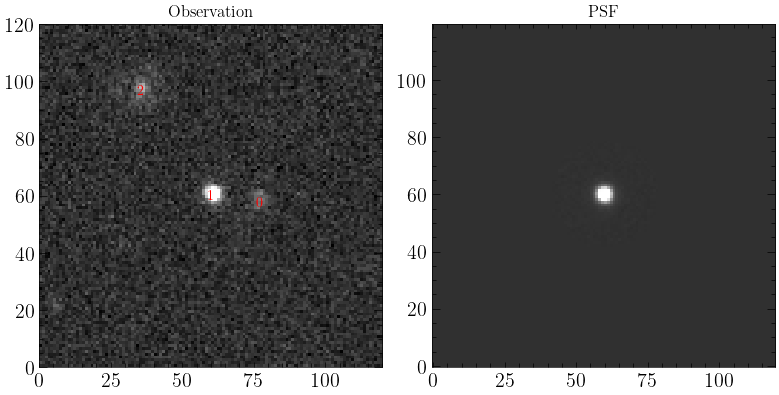

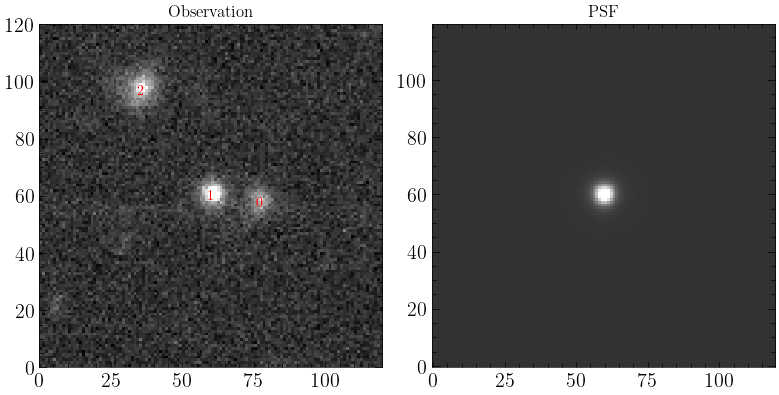

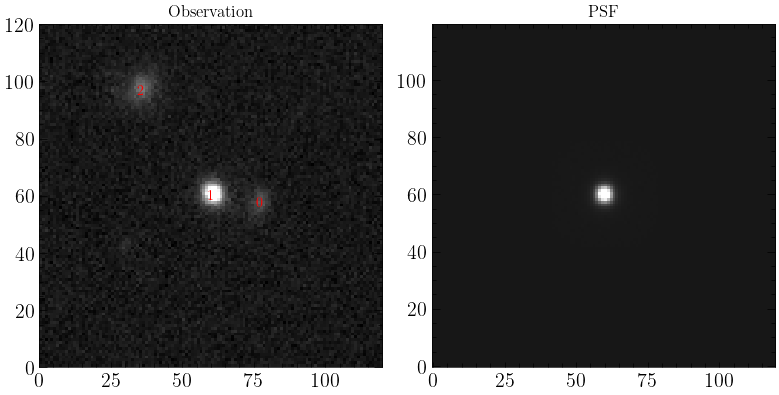

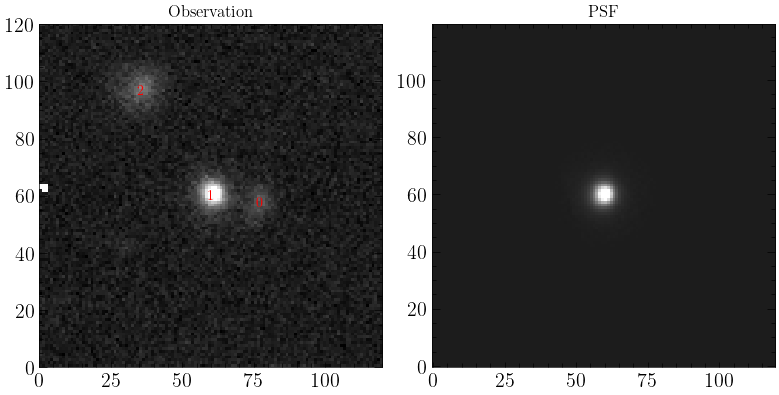

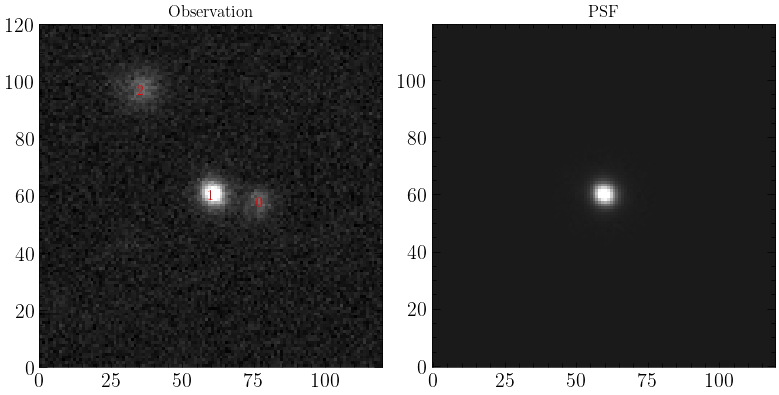

In [9]:
print(np.asarray(ra_dec).shape)
if np.asarray(ra_dec).shape==(2,):
    for ind,(obs, norm) in enumerate(zip(observations[:5], normsingle[:5])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=[ra_dec], show_psf=True)
else:    
    for ind,(obs, norm) in enumerate(zip(observations[:5], normsingle[:5])):
        scarlet.display.show_observation(obs, norm=norm, sky_coords=ra_dec, show_psf=True)
    

Create the PSF model and create the model frame based on the observations

Define the scarlet2 PSF model and model frame. Match the model frame to the observations.

In [10]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),observations_sc2[0].data.shape[-2],observations_sc2[0].data.shape[-1])), psf=frame_psf_sc2, channels=channels_sc2, wcs=wcs_hsc)
for obs in observations_sc2:
    obs.match(model_frame_sc2)

Initialize the scarlet2 morphologies based on scarlet1:

In [11]:
from galaxygrad import HSC_ScoreNet32

stepnum=1000
gal_step = 2e-3
AGN_step = 2e-3
from scarlet2 import nn
model_size = 32
count = 0
prior = nn.ScorePrior(
            model=HSC_ScoreNet32
        )
ra_dec = np.asarray(ra_dec)
print(ra_dec[0])
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,pos in enumerate(ra_dec):      
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(observations_sc2_old[0].frame.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pos[0],pos[1]]))
        centerpix = jnp.asarray([pospix[1],pospix[0]])
        print('CENTER',center,centerpix)
        if i==indtransient:    
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0]
            flux = jnp.asarray(flux)
           
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])

            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_agn =1e-3*peak_value2
            
            scarlet2.PointSource(
                    centerpix,
                    scarlet2.ArraySpectrum(jnp.asarray(flux)))#, stepsize=AGN_step, constraint=constraints.positive), epochs = channels_zeroed)#,constraint = scarlet2.PositiveConstraint())
                
            print('Making host galaxy')
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0]
            
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
                print(morph_init.shape[0],morph_init.shape[0]>30)
                if morph_init.shape[0]>30:
                    excess = morph_init.shape[0]-30
                    print('EXCESS',excess)
                    morph_init = morph_init[excess:-excess,excess:-excess]
                else:
                    padsize=[int((30-morph_init.shape[0])/2),int((30-morph_init.shape[1])/2)]
                    print('PADSIZE',padsize)
                    morph_init = np.pad(morph_init,(padsize[0], padsize[1]), 'edge') + 1e-12
                print(morph_init.shape)
                morph_init = morph_init/np.sum(morph_init)+1e-12
            except ValueError:
                print('Initializing as point source')
                #continue
                morph_init = morph_init/np.sum(morph_init)+1e-12
                if morph_init.shape[0]>30:
                    excess = morph_init.shape[0]-30
                    morph_init = morph_init[excess:-excess,excess:-excess]
                else:
                    padsize=[int((30-morph_init.shape[0])/2),int((30-morph_init.shape[1])/2)]
                    morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(padsize[0], padsize[1]), 'edge')
                morph_init = morph_init/np.sum(morph_init)+1e-12
            print(morph_init.shape)
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1

            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))

        else:
            print('Making other galaxy')
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0])
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
            except ValueError:
                print('Initializing as point source')
                morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(5, 5), 'edge')
            morph_init = morph_init/np.sum(morph_init)+1e-12
            print(morph_init.shape)
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1

            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))
pos_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    if i==indtransient:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=AGN_step)
        parameters += Parameter(scene.sources[i].morphology.center, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=pos_step)
 
    else:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
        parameters += Parameter(scene.sources[i].morphology.data, name=f"morph.{i}", constraint=constraints.positive, stepsize=morph_step)
        
scene.set_spectra_to_match(observations_sc2,parameters)

[150.1028073    2.55065891]
CENTER [150.10281    2.550659] [57.40203 76.82909]
Making other galaxy
(11, 11)
CENTER [150.10358     2.5507822] [60.042515 60.31447 ]
Making host galaxy
11 False
PADSIZE [9, 9]
(29, 29)
(29, 29)
CENTER [150.10474    2.552495] [96.741844 35.40664 ]
Making other galaxy
(11, 11)


from galaxygrad import HSC_ScoreNet32

stepnum=1000
gal_step = 2e-3
AGN_step = 2e-3
from scarlet2 import nn
model_size = 32
count = 0
prior = nn.ScorePrior(
            model=HSC_ScoreNet32
        )
ra_dec = np.asarray(ra_dec)
print(ra_dec[0])
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,pos in enumerate(ra_dec):      
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(observations_sc2_old[0].frame.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pos[0],pos[1]]))
        centerpix = jnp.asarray([pospix[1],pospix[0]])
        print('CENTER',center,centerpix)
        if i==indtransient:    
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0]
            flux = jnp.asarray(flux)
           
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])

            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_agn =1e-3*peak_value2
            
            scarlet2.PointSource(
                    centerpix,
                    scarlet2.ArraySpectrum(jnp.asarray(flux)))#, stepsize=AGN_step, constraint=constraints.positive), epochs = channels_zeroed)#,constraint = scarlet2.PositiveConstraint())
                
            print('Making host galaxy')
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0]
            
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
                print(morph_init.shape[0],morph_init.shape[0]>30)
                if morph_init.shape[0]>30:
                    excess = morph_init.shape[0]-30
                    print('EXCESS',excess)
                    morph_init = morph_init[excess:-excess,excess:-excess]
                else:
                    padsize=[int((30-morph_init.shape[0])/2),int((30-morph_init.shape[1])/2)]
                    print('PADSIZE',padsize)
                    morph_init = np.pad(morph_init,(padsize[0], padsize[1]), 'edge') + 1e-12
                print(morph_init.shape)
                morph_init = morph_init/np.sum(morph_init)+1e-12
            except ValueError:
                print('Initializing as point source')
                #continue
                morph_init = morph_init/np.sum(morph_init)+1e-12
                if morph_init.shape[0]>30:
                    excess = morph_init.shape[0]-30
                    morph_init = morph_init[excess:-excess,excess:-excess]
                else:
                    padsize=[int((30-morph_init.shape[0])/2),int((30-morph_init.shape[1])/2)]
                    morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(padsize[0], padsize[1]), 'edge')
                morph_init = morph_init/np.sum(morph_init)+1e-12
            print(morph_init.shape)
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1

            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))

        else:
            print('Making other galaxy')
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0])
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
            except ValueError:
                print('Initializing as point source')
                morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(5, 5), 'edge')
            morph_init = morph_init/np.sum(morph_init)+1e-12
            print(morph_init.shape)
            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1

            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))
pos_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    if i==indtransient:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=AGN_step)
        parameters += Parameter(scene.sources[i].morphology.center, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=pos_step)
 
    else:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
        parameters += Parameter(scene.sources[i].morphology.data, name=f"morph.{i}", constraint=constraints.positive, stepsize=morph_step)
        
scene.set_spectra_to_match(observations_sc2,parameters)

In [12]:
from galaxygrad import HSC_ScoreNet32

stepnum=1000
gal_step = 2e-3
AGN_step = 2e-3
from scarlet2 import nn
model_size = 32
count = 0
prior = nn.ScorePrior(
            model=HSC_ScoreNet32
        )
ra_dec = np.asarray(ra_dec)
print(ra_dec[0])
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,pos in enumerate(ra_dec):      
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(observations_sc2_old[0].frame.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pos[0],pos[1]]))
        centerpix = jnp.asarray([pospix[1],pospix[0]])
        print('CENTER',center,centerpix)
        if i==indtransient:    
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0]
            flux = jnp.asarray(flux)
           
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])

            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_agn =1e-3*peak_value2
            
            scarlet2.PointSource(
                    centerpix,
                    scarlet2.ArraySpectrum(jnp.asarray(flux)))#, stepsize=AGN_step, constraint=constraints.positive), epochs = channels_zeroed)#,constraint = scarlet2.PositiveConstraint())
                
            print('Making host galaxy')
            flux = np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0]
            
            sersic = scarlet2.SersicMorphology(
                                        center = #scarlet2.module.Parameter(
                                                jnp.asarray(np.asfarray(center)),
                                                #constraint=constraints.positive,
                                                #stepsize=1e-2),
                                        ellipticity = jnp.asarray([0.1,0.1]),#scarlet2.module.Parameter(jnp.asarray([0.1,0.1]),
                                            #constraint=constraints.interval(0,1),
                                            #stepsize=1e-3),
                                        size= jnp.asarray(3.0),#scarlet2.module.Parameter(jnp.asarray(3.0),  
                                                #constraint=constraints.interval(1.0,15),
                                                #stepsize=1e-2),
                                        n=jnp.asarray(1.5),#scarlet2.module.Parameter(jnp.asarray(1.5),
                                            #constraint=constraints.interval(.5,10),
                                            #stepsize=1e-3),

                        )
            scarlet2.Source(
                center,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall) ,sersic)
           
        else:
            print('Making other galaxy')
            flux = jnp.asarray(np.asarray(initialization.pixel_spectrum(observations_sc2, center))[:,0][inds0])
            try:
                morph_init = initialization.adaptive_gaussian_morph(observations_sc2[0], center)
            except ValueError:
                print('Initializing as point source')
                morph_init = np.pad(observations_sc2[0].frame.psf()[0,:,:]-np.min(observations_sc2[0].frame.psf()),(5, 5), 'edge')
            morph_init = morph_init/np.sum(morph_init)+1e-12

            morph_init = jnp.asarray(morph_init)
            n_steps, peak_value = stepnum, 1

            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])


            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
            test_step_gal =5e-3*peak_value2

            scarlet2.Source(
                centerpix,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                scarlet2.ArrayMorphology(morph_init))
pos_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    if i==indtransient:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=AGN_step)
        parameters += Parameter(scene.sources[i].morphology.center, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=pos_step)
    elif i==indtransient+1:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
        parameters += Parameter(scene.sources[i].morphology.center, name=f"morph.{i}", constraint=constraints.positive, stepsize=pos_step)
        parameters += Parameter(scene.sources[i].morphology.ellipticity, name=f"morph.{i}", constraint=constraints.interval(0,1), stepsize=1e-3)
        parameters += Parameter(scene.sources[i].morphology.size, name=f"morph.{i}", constraint=constraints.interval(1.0,15), stepsize=5e-2)
        parameters += Parameter(scene.sources[i].morphology.n, name=f"morph.{i}", constraint=constraints.interval(.5,10), stepsize=1e-3)
    else:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
        parameters += Parameter(scene.sources[i].morphology.data, name=f"morph.{i}", constraint=constraints.positive, stepsize=morph_step)
        
scene.set_spectra_to_match(observations_sc2,parameters)

[150.1028073    2.55065891]
CENTER [150.10281    2.550659] [57.40203 76.82909]
Making other galaxy
CENTER [150.10358     2.5507822] [60.042515 60.31447 ]
Making host galaxy
CENTER [150.10474    2.552495] [96.741844 35.40664 ]
Making other galaxy


Initialize scarlet2 sources using morphologies and fluxes from scarlet1

Plot scarlet2 initializations

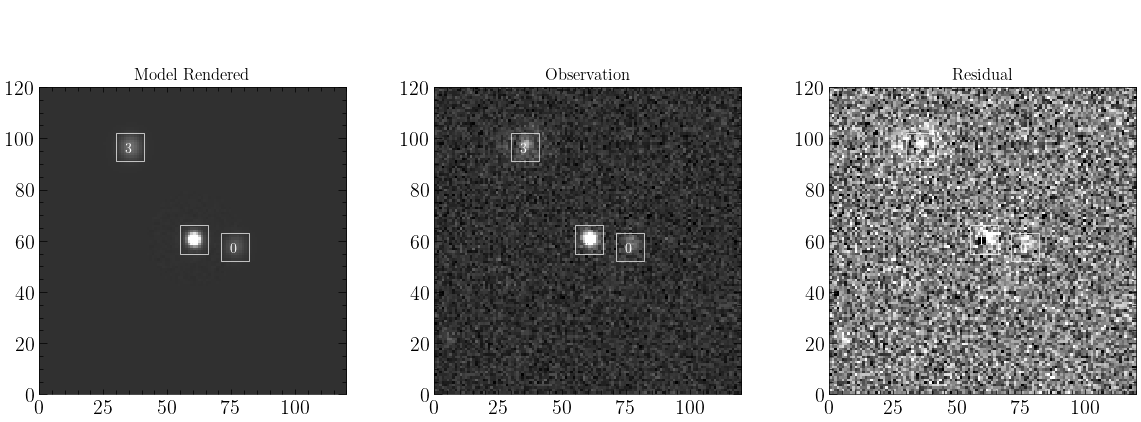

<Figure size 600x450 with 0 Axes>

In [13]:

scarlet2.plot.scene(
    scene,
    observation=np.asarray(observations_sc2)[0],
    norm=np.asarray(normsingle)[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()
plt.clf()

#Show the initalization point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene.sources[i].morphology()
    else:
        y = scene.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method)#,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.show()
plt.clf()

In [14]:
#Free up the AGN position parameter so that it can be refitted
n_steps, peak_value_pos = stepnum, 1
schedulepos = optax.cosine_onecycle_schedule(n_steps, peak_value_pos, final_div_factor=1)
pos_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
flux = scene.sources[indtransient].spectrum.data

#Fit the scene
scene_ = scene.fit(observations_sc2, parameters,max_iter=stepnum, e_rel=1e-6, schedule=schedulepos)

100%|██████████| 1000/1000 [00:21<00:00, 47.56it/s, loss=9502291.00, max_change=0.000037]


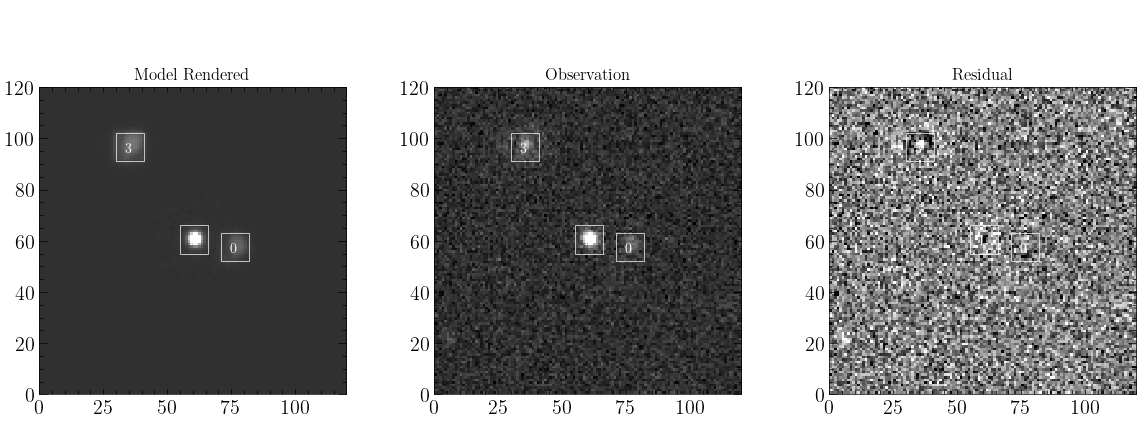

<Figure size 600x450 with 0 Axes>

In [15]:
scarlet2.plot.scene(
    scene_,
    observation=np.asarray(observations_sc2)[0],
    norm=np.asarray(normsingle)[0],
    channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()
plt.clf()

#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

[4754, 7711, 6175, 9762, 8898]


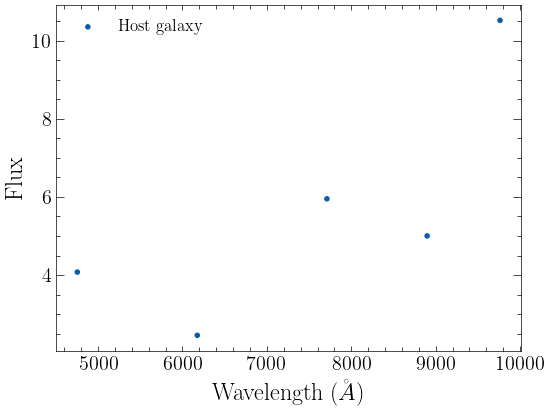

sample:  44%|████▍     | 286/650 [32:34<43:55,  7.24s/it, 1023 steps of size 2.47e-04. acc. prob=0.83]  

In [ ]:
from numpyro.infer.initialization import init_to_sample
getquickgalaxySED=True
getgalaxySED=True
wave=waveselect
print(wave)
fac=1
if getquickgalaxySED==True:
    
    out = np.column_stack((wave,scene_.sources[indtransient+1].spectrum.data))
    np.savetxt(plotdir+'/sed_quick.txt',np.asarray(out,dtype=str),fmt='%s')
    #fac = np.sum(scene_.sources[indtransient+1].morphology.data,axis=(-2,-1))
    plt.scatter(wave,fac*scene_.sources[indtransient+1].spectrum.data,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_SED_GAL_quick.png')
    plt.show()
    plt.clf()
    
if getgalaxySED==True:
    parameters = scene_.make_parameters()
    p = scene_.sources[indtransient+1].morphology.center
    prior = dist.Normal(p, scale=1)
    parameters += Parameter(p, name=f"morphology.center:"+str(indtransient+1), prior=prior)
    p = scene_.sources[indtransient+1].morphology.ellipticity
    prior = dist.Normal(p, scale=1)
    parameters += Parameter(p, name=f"morphology.ellipticity:"+str(indtransient+1), prior=dist.Normal(p, scale=0.5))
    p = scene_.sources[indtransient+1].morphology.size
    prior = dist.Normal(p, scale=1)
    parameters += Parameter(p, name=f"morphology.size:"+str(indtransient+1), prior=dist.Normal(p, scale=1.0))
    p = scene_.sources[indtransient+1].morphology.n
    prior = dist.Normal(p, scale=1)
    parameters += Parameter(p, name=f"morphology.n:"+str(indtransient+1), prior=dist.Normal(p, scale=0.5))
    p = scene_.sources[indtransient+1].spectrum.data
    prior = dist.Normal(p, scale=1)
    parameters += Parameter(p, name=f"spectrum:"+str(indtransient+1), prior=prior)
    p = scene_.sources[indtransient].spectrum.data
    prior = dist.Normal(p, scale=1)
    parameters += Parameter(p, name=f"spectrum:"+str(indtransient), prior=prior)
 
    mcmc = scene_.sample(observations_sc2,parameters,num_warmup=150, num_samples=500, dense_mass=True, init_strategy=init_to_sample) 

    q = mcmc.get_samples()['spectrum:'+str(indtransient+1)] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0)
    fac = np.sum(scene_.sources[indtransient+1].morphology(),axis=(-2,-1))
    galfluxes = []
    galfluxerrors = []
    for i,b in zip(range(q1.shape[1]),inds0):
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2)
        galfluxes.append(q1[2][i]*fac)
        galfluxerrors.append((q1[3][i]-q1[1][i])/2*fac)
    mcmc.print_summary()
    #corner.corner(mcmc).show()
    #plt.savefig(plotdir+'/'+srcname+'_galflux_corner.png')
    plt.show()
    plt.clf()
    sedgal = np.asfarray(galfluxes)
    sedgalerr = np.asfarray(galfluxerrors)

    print(2.5*np.log10(63095734448.01944/sedgal))
    plt.errorbar(wave,22.5-np.log10(sedgal),yerr= 1.0857* sedgalerr/sedgal,marker='.',linestyle='',label='Host galaxy')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.savefig(plotdir+'/'+srcname+'_SED_GAL.png')
    plt.show()
    plt.clf()
    outsedhead=['WAVE_CEN','GALFLUX','GALFLUXERR']
    outsed=np.column_stack((wave,sedgal,sedgalerr))
    outsed = np.vstack((outsedhead,outsed))
    print(outsed)
    np.savetxt(plotdir+'/sedgal.txt',np.asarray(outsed,dtype=str),fmt='%s')
    
    q = mcmc.get_samples()['spectrum:'+str(indtransient)]
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1)) 
    fluxes = [] 
    fluxerrors = [] 
    for i,b in zip(range(q1.shape[1]),bandind): 
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2) 
        fluxes.append(q1[2][i]*fac) 
        fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)

    mcmc.print_summary() 

    zps = np.asfarray(zps)
    fluxes = np.asfarray(fluxes)
    fluxerrors = np.asfarray(fluxerrors)
    #flux = scene.sources[indtransient].spectrum.data
    #fluxgal = scene.sources[indgal].spectrum.data
    times=np.asfarray(times)
    print(times,epochs,flux,fluxerrors)


    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
    #fac = np.sum(scene_.sources[i].morphology.data,axis=(-2,-1))
    
    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        plt.errorbar(times[epochs==b]-57700,fluxes[epochs==b],yerr = fluxerrors[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Flux')
    plt.legend()
    plt.title(srcname)
    plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
    plt.show()
    plt.clf()
    outlchead=['MJD','FLUX','FLUXERR','BAND']
    outlc=np.column_stack((times,fluxes,fluxerrors,epochs))
    outlc = np.vstack((outlchead,outlc))
    np.savetxt(plotdir+'/lc.txt',np.asarray(outlc,dtype=str),fmt='%s')
    sed=[]
    sederr=[]
    for b,c in zip(bandall,['green','orange','red','purple','blue']):
        sed.append(np.mean(fluxes[epochs==b]))
        sederr.append(np.std(fluxes[epochs==b]))
        plt.errorbar(times[epochs==b]-57700,25-2.5*np.log10(fluxes[epochs==b]),yerr = 1.0857*fluxerrors[epochs==b]/fluxes[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_lc_mag.png')
    plt.show()

print(channels)
print(observations_sc2[0].renderer.channel_map)
observations_sc2_arr = np.asarray(observations_sc2)
scarlet2.plot.sources(scene_,observation=observations_sc2_arr[inds0],channel_map=None,show_hallucination=True)

In [ ]:
fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
times=np.asarray(times)
nbin=10
flux = scene_.sources[indtransient].spectrum.data
for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
    
        #plt.scatter(times[epochs==b]-57700,flux[epochs==b]-np.median(flux[epochs==b]),linestyle='',label=b,color=c,marker='.')

        hist,bin_edges=np.histogram(times[epochs==b],bins=int((np.max(times[epochs==b])-np.min(times[epochs==b]))/nbin))
        print(len(bin_edges))
        binsize=bin_edges[1]-bin_edges[0]

        binned = np.asarray([np.median(flux[epochs==b][(times[epochs==b]>bin_edges[j]) & (times[epochs==b]<bin_edges[j+1])]) for j in range(len(bin_edges)-1)])
        print(binned)
        nonzero = np.argwhere(~np.isnan(binned))[:,0]
        #bin_edges = bin_edges[nonzero]
        print([flux[epochs==b][(times[epochs==b]>bin_edges[j]) & (times[epochs==b]<bin_edges[j]+binsize)] for j in nonzero])
        binned_error = np.asarray([np.std(np.asarray(flux[epochs==b][(times[epochs==b]>bin_edges[j]) & (times[epochs==b]<bin_edges[j]+binsize)])) for j in nonzero])
        binned_error = np.clip(binned_error,a_min=10*bgsingle[bind],a_max=100)
        binned = binned[nonzero]
        mags = 25-np.log10(binned)
        plt.errorbar(bin_edges[nonzero][mags<27]+binsize-57700,mags[mags<27],yerr=1.0857*binned_error[mags<27]/binned[mags<27],label=b,color=c,marker='.',linestyle='')


        plt.xlabel('MJD-57700')

#plt.xlim((0,300))
#plt.ylim((22.0,22.3))
plt.ylabel('Magnitude')
plt.legend(frameon=True)
#plt.title(srcname,fontsize=12)
plt.gca().invert_yaxis()

plt.savefig(plotdir+'/'+srcname+'_lc_flux.pdf')
#plt.show()
plt.xlim((0,250))
print('SAVED',plotdir+'/'+srcname+'_lc_flux_zoom.pdf')
plt.savefig(plotdir+'/'+srcname+'_lc_flux_zoom.pdf')
plt.show()

In [ ]:
channels = np.asarray(channels)
observations_sc2_arr = np.asarray(observations_sc2)
normsinglearr = np.asarray(normsingle)
for i,(chan,obs,obs1,norm) in enumerate(zip(channels[inds0],observations_sc2_arr[inds0],obssinglearr[inds0],normsinglearr[inds0])):
        model_ = obs.render(scene_())
        try:
            scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, coverage='intersection', model_psf=model_psf)[0],
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           add_labels=False,
                           figsize=(8,3)
                          )
        except:
            pass
        plt.savefig(plotdir+'/scarlet2fit'+chan+'.pdf')
        plt.show()
        plt.clf()

In [ ]:
makelc = False
if makelc:
    scene_.set_info(scene_.parameters.keys(), fixed=True)
    scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient].spectrum.data, 0.05*scene_.sources[indtransient].spectrum.data))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01*scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2))
    mcmc = scene_.sample(observations_sc2,num_warmup=100, num_samples=200)
    q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data']
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0)
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
    fluxes = []
    fluxerrors = []
    for i,b in zip(range(q1.shape[1]),bandind):
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2)
        fluxes.append(q1[2][i]*fac)
        fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)
    
    mcmc.print_summary()
    import corner
    corner.corner(mcmc).show()
    plt.savefig(plotdir+'/'+srcname+'_transientflux_corner.png')
    plt.clf()

In [ ]:
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene_.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
        print(y)
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,vmin = np.max([np.min(np.log(y)[np.log(y)>-50]),-50]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

In [ ]:
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig=plt.figure(figsize=(4,4))#, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)

y = scene_.sources[indtransient+1].morphology.data
plt.imshow(np.log(y), cmap = cmap,interpolation=int_method,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
#plt.set_title(f"source {i}", fontsize = 18)
#plt.invert_yaxis()
#plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_galaxy.pdf')
plt.show()
plt.clf()

In [ ]:
for i,(chan,obs,norm) in enumerate(zip(channels[:5],observations_sc2_arr[:5],normsinglearr[:5])):
        model_ = obs.render(scene_())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           model = model_,
                           frame = model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )
        plt.savefig(plotdir+'/scarlet2fit'+chan+'.png')
        plt.show()
        plt.clf()
#import sys
#sys.exit()

In [ ]:
getmorph=False
if getmorph==True:
    scene_.set_info(scene_.parameters.keys(), fixed=True) 
    scene_.set_info('sources.'+str(indtransient+1)+'.morphology.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient+1].morphology(), 0.1*scene_.sources[indtransient+1].morphology()))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2)) 
    scene_.set_info('sources.'+str(indtransient+1)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient+1].spectrum.data, 0.1*scene_.sources[indtransient+1].spectrum.data))
    mcmc = scene_.sample(observations_sc2,num_warmup=50, num_samples=100) 
    q = mcmc.get_samples()['sources.'+str(indtransient+1)+'.morphology.data'] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    corner.corner(mcmc).show() 
    plt.savefig(plotdir+'/'+srcname+'_transientflux_corner.png')
    plt.show()
    plt.clf()

In [ ]:
getphotometry=False
if getphotometry==True:
    scene_.set_info(scene_.parameters.keys(), fixed=True) 
    scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, prior=dist.Normal(scene_.sources[indtransient].spectrum.data, 0.01*scene_.sources[indtransient].spectrum.data))#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))##01scene.sources[5].spectrum.data))#dist.Uniform(scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2)) 
    mcmc = scene_.sample(observations_sc2,num_warmup=50, num_samples=100) 
    q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data'] 
    q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1)) 
    fluxes = [] 
    fluxerrors = [] 
    for i,b in zip(range(q1.shape[1]),bandind): 
        print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2) 
        fluxes.append(q1[2][i]*fac) 
        fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)

    mcmc.print_summary() 

    #corner.corner(mcmc).show() 
    #plt.savefig(plotdir+'/'+srcname+'_transientflux_corner.png')
    #plt.show()
    #plt.clf()
    zps = np.asfarray(zps)
    fluxes = np.asfarray(fluxes)
    fluxerrors = np.asfarray(fluxerrors)
    #flux = scene.sources[indtransient].spectrum.data
    #fluxgal = scene.sources[indgal].spectrum.data
    times=np.asfarray(times)
    print(times,epochs,flux,fluxerrors)


    fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
    #fac = np.sum(scene_.sources[i].morphology.data,axis=(-2,-1))
    
    for bind,(b,c) in enumerate(zip(bandall,['green','orange','red','purple','blue'])):
        plt.errorbar(times[epochs==b]-57700,fluxes[epochs==b],yerr = fluxerrors[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Flux')
    plt.legend()
    plt.title(srcname)
    plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
    plt.show()
    plt.clf()
    outlchead=['MJD','FLUX','FLUXERR','BAND']
    outlc=np.column_stack((times,fluxes,fluxerrors,epochs))
    outlc = np.vstack((outlchead,outlc))
    np.savetxt(plotdir+'/lc.txt',np.asarray(outlc,dtype=str),fmt='%s')
    sed=[]
    sederr=[]
    for b,c in zip(bandall,['green','orange','red','purple','blue']):
        sed.append(np.mean(fluxes[epochs==b]))
        sederr.append(np.std(fluxes[epochs==b]))
        plt.errorbar(times[epochs==b]-57700,25-2.5*np.log10(fluxes[epochs==b]),yerr = 1.0857*fluxerrors[epochs==b]/fluxes[epochs==b],linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    plt.xlabel('MJD-57700')
    plt.xlim((0,300))
    #plt.ylim((22.0,22.3))
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(plotdir+'/'+srcname+'_lc_mag.png')
    plt.show()

In [ ]:
print(scene_.sources[indtransient].morphology.center)
scene_.set_info(scene_.parameters.keys(), fixed=True) 
scene_.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False, prior=dist.Normal(scene_.sources[indtransient].morphology.center, 2.0))
mcmc = scene_.sample(observations_sc2,num_warmup=20, num_samples=100)
q = mcmc.get_samples()['sources.'+str(indtransient)+'.morphology.center'] 
q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
print(q1)
centerAGN = np.asfarray([q1[2,0],q1[2,1]])
errorAGN = np.asarray([np.abs(q1[3,0]-q1[1,0]),np.abs(q1[3,1]-q1[1,1])])
print(centerAGN,errorAGN)
try:
    corner.corner(mcmc).show() 
    plt.savefig(plotdir+'/'+srcname+'_transientcenter_corner.png')
    plt.show()
    plt.clf()
except:
    pass

In [ ]:
obs_subtracted=[]
for i,(chan,obs) in enumerate(zip(channels_sc2,observations_sc2_arr)):
    newdata = copy.deepcopy(np.asarray(obs.data)) 
    for isource,src in enumerate(scene_.sources):
        #print(isource)
        if isource==indtransient+1:
            continue
        model_ = obs.render(scene_.sources[isource]())
        
        #print(newdata.shape,model_.shape,scene_.sources[isource].morphology.bbox)#.slices)
        #print(scene_.sources[isource].bbox)
        #scene_.sources[isource].morphology.bbox.origin[0] or 
        boxslice = scene_.sources[isource].bbox.slices
        #print(boxslice)
        overlap1,overlap2 = bbox.overlap_slices(scene_.sources[indtransient].bbox, scene_.sources[isource].bbox)
        try:
            newdata[boxslice] = newdata[boxslice] - model_
            #newdata[overlap1] = newdata[overlap1] - model_[overlap2]
        except TypeError:
            print('Slicing operation failure',i,isource)
    plt.imshow(newdata[0])
    obs2 = scarlet2.Observation(jnp.asarray(newdata), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.frame.psf())),channels=obs.frame.channels)

    obs2.match(model_frame_sc2)
    obs_subtracted.append(obs2)


obs_subtractedarr = np.asarray(obs_subtracted)

for i,(chan,obs,norm) in enumerate(zip(np.asarray(channels)[inds0],obs_subtractedarr[inds0],normsinglearr[inds0])):
    model_ = obs.render(scene2())
    scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           model = model_,
                           frame = model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

    plt.savefig(plotdir+'/scarlet2fit_sub'+chan+'.png')

In [ ]:
obs_subtractedarr = np.asarray(obs_subtracted)
multichannel = []
multiimage=[]
multivar=[]
multipsf=[]
for i in range(len(bandind)-1):
    bind = np.argwhere(np.asarray(bandind)==i)[:,0]
    if len(bind)==0:
        continue
    weights = np.asarray([obs.weights for obs in obs_subtractedarr[bind]])
    weights[weights==0] = 1e-10
    multivar.append(np.mean(np.asarray([obs.weights for obs in obs_subtractedarr[bind]]),axis=0)[0])
    multiimage.append(np.average(np.asarray([obs.data for obs in obs_subtractedarr[bind]]),axis=0,weights=weights)[0])
    
    multipsf.append(np.mean(np.asarray([obs.frame.psf() for obs in obs_subtractedarr[bind]]),axis=0)[0])
    channel_sc2 = bandall[i]#(bandall[i], '0')
    
    multichannel.append(channel_sc2)
obs_sc2 = scarlet2.Observation(jnp.asarray(multiimage), jnp.asarray(multivar),psf=scarlet2.ArrayPSF(jnp.asarray(multipsf)),channels=multichannel)#,wcs=w)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((np.asarray(multiimage).shape[0],np.asarray(multiimage).shape[-1],np.asarray(multiimage).shape[-2])), psf=frame_psf_sc2, channels=multichannel)

In [ ]:
with scarlet2.Scene(model_frame_sc2) as scene3:
    for i,src in enumerate(scene_.sources):
        #prior = nn.ScorePrior(model=prior_model, transform=transform, model_size=64)
        #prior = scarlet2.nn.NNPrior(trained_model='hsc', log_space=False,shape=jnp.shape(morph_init[i]))# hsc, ZTF
        #pos = np.asfarray([src.center[0]-offset[0],src.center[1]-offset[1]])      
        if i==indtransient:
            continue
        else:
            pos = np.asfarray([src.morphology.bbox.center[0]-offset[0]-0.5,src.morphology.bbox.center[1]-offset[1]-0.5])
            
            flux = src.spectrum.data#src.spectrum.get_model()#[inds0])
            #flux[flux<0] = 1e-10
            #flux[-1]=flux[-1]*1.2
            scarlet2.Source(
                pos,
                scarlet2.ArraySpectrum(Parameter(jnp.asarray(flux), stepsize=1e-2*flux, constraint=constraints.positive)),scarlet2.ArrayMorphology(Parameter(morph_init[i], stepsize=1e-4, prior=prior,constraint=constraints.positive)))

            #scarlet2.Source(
            #    pos,
            #    scarlet2.StaticArraySpectrum(Parameter(jnp.asarray(flux), stepsize=1e-2*flux,constraint=constraints.positive),filters=bandall),scarlet2.ArrayMorphology(Parameter(morph_init[i], stepsize=1e-2, prior=prior)))
            
        print(flux)     

In [ ]:
print(obs_sc2.data.shape)
model_ = obs_sc2.render(scene3())
scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs_sc2,
                           model = model_,
                           frame = model_frame_sc2,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           add_labels=False,
                           figsize=(12,4)
                          )

In [ ]:
xx, yy = np.meshgrid(np.linspace(-5,5,301), np.linspace(-5,5,301))
PSF = np.exp(-(xx**2 + yy**2)/0.5**2)
PSF /= np.sum(PSF)
PSF = ap.image.PSF_Image(data=PSF, pixelscale = pixelscale)

#PSF = ap.image.PSF_Image(data=np.asfarray(obs_subtracted[0].frame.psf()[0]), pixelscale = pixelscale)
targets_all=[]
for i,b in enumerate(bands):
    target = ap.image.Target_Image(
        data = np.asfarray(multiimage[i]),#obs_subtracted[0].data[0]),
        #wcs = observations[0].wcs,
        pixelscale = pixelscale, # Every target image needs to know it's pixelscale in arcsec/pixel
        zeropoint = 22.5, # optionally, you can give a zeropoint to tell AstroPhot what the pixel flux units are
        variance = np.asfarray(1/multivar[i])#obs_subtracted[0].weights[0])#np.ones(target_data.shape)/1e3, # set the variance for this image (in general it should be more accurate than this)
    )
    targets_all.append(target)
fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig3, ax3, target)
plt.show()

target_full = ap.image.Target_Image_List(tuple(targets_all))

In [ ]:
origin =np.asarray(obs_subtractedarr[0].data.shape[-2:])/2.0+0.5# [60,60]#centergal#scene_.sources[indtransient+1].morphology.bbox.origin
boxshape = scene_.sources[indtransient+1].morphology.bbox.shape
print('ORIGIN',origin)
window = np.asfarray([[origin[0]-int(boxshape[0]/2.2),origin[0]+int(boxshape[0]/2.2)],[origin[1]-int(boxshape[1]/2.2),origin[1]+int(boxshape[1]/2.2)]])
model_list = []

sub_list=[]
for i, b in enumerate(bands):
        # create the submodels for this object

    sub_list.append(
            ap.models.AstroPhot_Model(
            name = b,
            model_type = "sersic galaxy model", # we use spline models for the r-band since it is well resolved
            target = targets_all[i],
            window = window,
            psf_mode = "none",
            parameters = {"center": np.asfarray(origin)*pixelscale, "q": 0.6, "PA": 160*np.pi/180, "n": 2, "Re": 3, "Ie": 1},
            #parameters = {"q": 0.3},
            ))
    if i>0:
        sub_list[-1].add_equality_constraint(sub_list[0], ["center", "q", "PA", "n", "Re"])
   


model_list.append(
    ap.models.AstroPhot_Model(
            name = "host",
            model_type = "group model",
            target = target_full,
            models = sub_list,
        )
    )

# Make the full model for this system of objects
MODEL = ap.models.AstroPhot_Model(
    name = f"full model",
    model_type = "group model",
    target = target_full,
    models = model_list,
)
fig, ax = plt.subplots(1,len(waveselect), figsize = (20,5))
ap.plots.target_image(fig, ax, MODEL.target, flipx=True)
ap.plots.model_window(fig, ax, MODEL)
for i,b in enumerate(bands):
    ax[i].set_title(b+" image")

plt.show()

In [ ]:
MODEL.initialize()

result = ap.fit.LM(MODEL, verbose = 1).fit()

fig1, ax1 = plt.subplots(1, 5, figsize = (24,4))
ap.plots.target_image(fig1, ax1, MODEL.target, window = MODEL.window, flipx=True)
for i,b in enumerate(bands):
    ax[i].set_title(b+" image")
plt.show()

In [ ]:
fig1, ax1 = plt.subplots(1, 5, figsize = (24,4))
ap.plots.model_image(fig1, ax1, MODEL, flipx=True)
for i,b in enumerate(bands):
    ax[i].set_title(b+" image")
plt.show()


In [ ]:
fig1, ax1 = plt.subplots(1, 5, figsize = (24,4))
ap.plots.residual_image(fig1, ax1, MODEL, flipx=True)
for i,b in enumerate(bands):
    ax[i].set_title(b+" image")
plt.show()

In [ ]:
result.update_uncertainty()
for P in MODEL.parameters:
    print(f"parameter {P.name} is: {P.value.detach().cpu().tolist()} +- {P.uncertainty.detach().cpu().tolist()}")
paramnames = ["center", "q", "PA", "n", "Re", "Ie"]
#print(MODEL.models['host'].parameters['R:'+paramnames[0]].value)#['r:Ie'])#['R'].parameters.get_values_as_tuple('R'))#['center'])
#wave = [4754,7711,6175,9762,8898]
sb = bandselect[0]
print(window)
galfitcenter = np.asfarray(MODEL.models['host'].parameters[sb+':center'].value.detach().cpu().tolist())
print(galfitcenter)
galfitcenter = galfitcenter/pixelscale#+window[:,0]#+origin-np.asfarray(boxshape)/2.0
print(galfitcenter)
galfitcentererror = np.asfarray(MODEL.models['host'].parameters[sb+':center'].uncertainty.detach().cpu().tolist())
#galpos_para = 

centerAGN = scene_.sources[indtransient].morphology.center
offsetAGN = np.linalg.norm(galfitcenter - centerAGN)*pixelscale#*0.168)
sumerror = errorAGN*pixelscale+galfitcentererror*pixelscale
totalerror = np.sqrt(sumerror[0]**2+sumerror[1]**2)#*pixelscale

print([offsetAGN,sumerror[0],sumerror[1],totalerror,float(centerAGN[0]),float(centerAGN[1]),galfitcenter[0],galfitcenter[1]])
np.savetxt(plotdir+'/offset_parametric.txt',np.asarray([offsetAGN,sumerror[0],sumerror[1],totalerror,float(centerAGN[0]),float(centerAGN[1]),galfitcenter[0],galfitcenter[1]],dtype=str),fmt='%s')


sedgal =[]
sedgalerror =[]
for b in bandselect:
    sedgal.append(MODEL.models['host'].parameters[b+':Ie'].value.detach().cpu().tolist())
    sedgalerror.append(MODEL.models['host'].parameters[b+':Ie'].uncertainty.detach().cpu().tolist())
paramout=[]
paramouterr=[]
for n in paramnames:
    if n=='center':
        paramout.append(MODEL.models['host'].parameters[sb+':'+n].value.detach().cpu().tolist()[0])
        paramout.append(MODEL.models['host'].parameters[sb+':'+n].value.detach().cpu().tolist()[0])
        paramouterr.append(MODEL.models['host'].parameters[sb+':'+n].uncertainty.detach().cpu().tolist()[0])
        paramouterr.append(MODEL.models['host'].parameters[sb+':'+n].uncertainty.detach().cpu().tolist()[1])
    else:
        paramout.append(MODEL.models['host'].parameters[sb+':'+n].value.detach().cpu().tolist())
        paramouterr.append(MODEL.models['host'].parameters[sb+':'+n].uncertainty.detach().cpu().tolist())
outparam=np.column_stack((['center0','center1']+paramnames[1:],paramout,paramouterr))
print(bandselect,waveselect,sedgal,sedgalerror)
np.savetxt(plotdir+'/galfit_params.txt',np.asarray(outparam,dtype=str),fmt='%s')                                                   
plt.errorbar(waveselect,sedgal,yerr=sedgalerror,marker='.',linestyle='',label='Host galaxy')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.legend()
plt.savefig(plotdir+'/'+srcname+'_SED_GAL.png')
plt.show()
plt.clf()
outsedhead=['WAVE_CEN','GALFLUX','GALFLUXERR']
outsed=np.column_stack((waveselect,sedgal,sedgalerror))
outsed = np.vstack((outsedhead,outsed))
print(outsed)
np.savetxt(plotdir+'/sed_parametric.txt',np.asarray(outsed,dtype=str),fmt='%s')


In [ ]:
fnremove = glob.glob(imagedir+'/warps-HSC-*-*-pdr3_dud*/warp-*.fits')
for fn in fnremove:
    os.remove(fn)
fnremove = glob.glob(imagedir+'/psf-*HSC-*.fits')
for fn in fnremove:
    os.remove(fn)

## 